# 初步数据分析

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib import rcParams
import warnings
warnings.filterwarnings('ignore')

In [2]:
sns.set()
sns.set_context(
    "notebook",
    font_scale=1.5,
    rc={
        "figure.figsize": (11, 8),
        "axes.titlesize": 18
    }
)
rcParams['figure.figsize'] = 11, 8

In [3]:
df = pd.read_csv(
    'https://labfile.oss.aliyuncs.com/courses/1283/mlbootcamp5_train.csv', sep=';')
print('Dataset size: ', df.shape)
df.head()

Dataset size:  (70000, 13)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


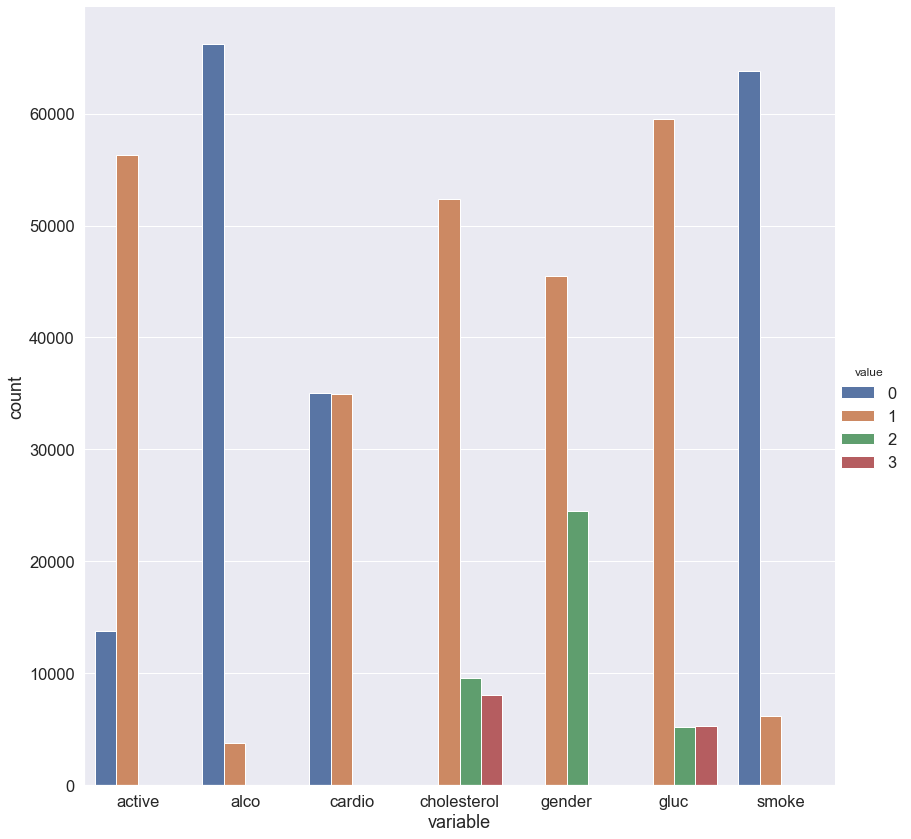

In [4]:
df_uniques = pd.melt(frame=df, value_vars=['gender', 'cholesterol',
                                           'gluc', 'smoke', 'alco',
                                           'active', 'cardio'])
df_uniques = pd.DataFrame(df_uniques.groupby(['variable',
                                              'value'])['value'].count()) \
    .sort_index(level=[0, 1]) \
    .rename(columns={'value': 'count'}) \
    .reset_index()

sns.catplot(x='variable', y='count', hue='value',
            data=df_uniques, kind='bar', height=12)

按目标值分割数据集，这样往往可以通过绘图结果快速找出相对重要的特征。

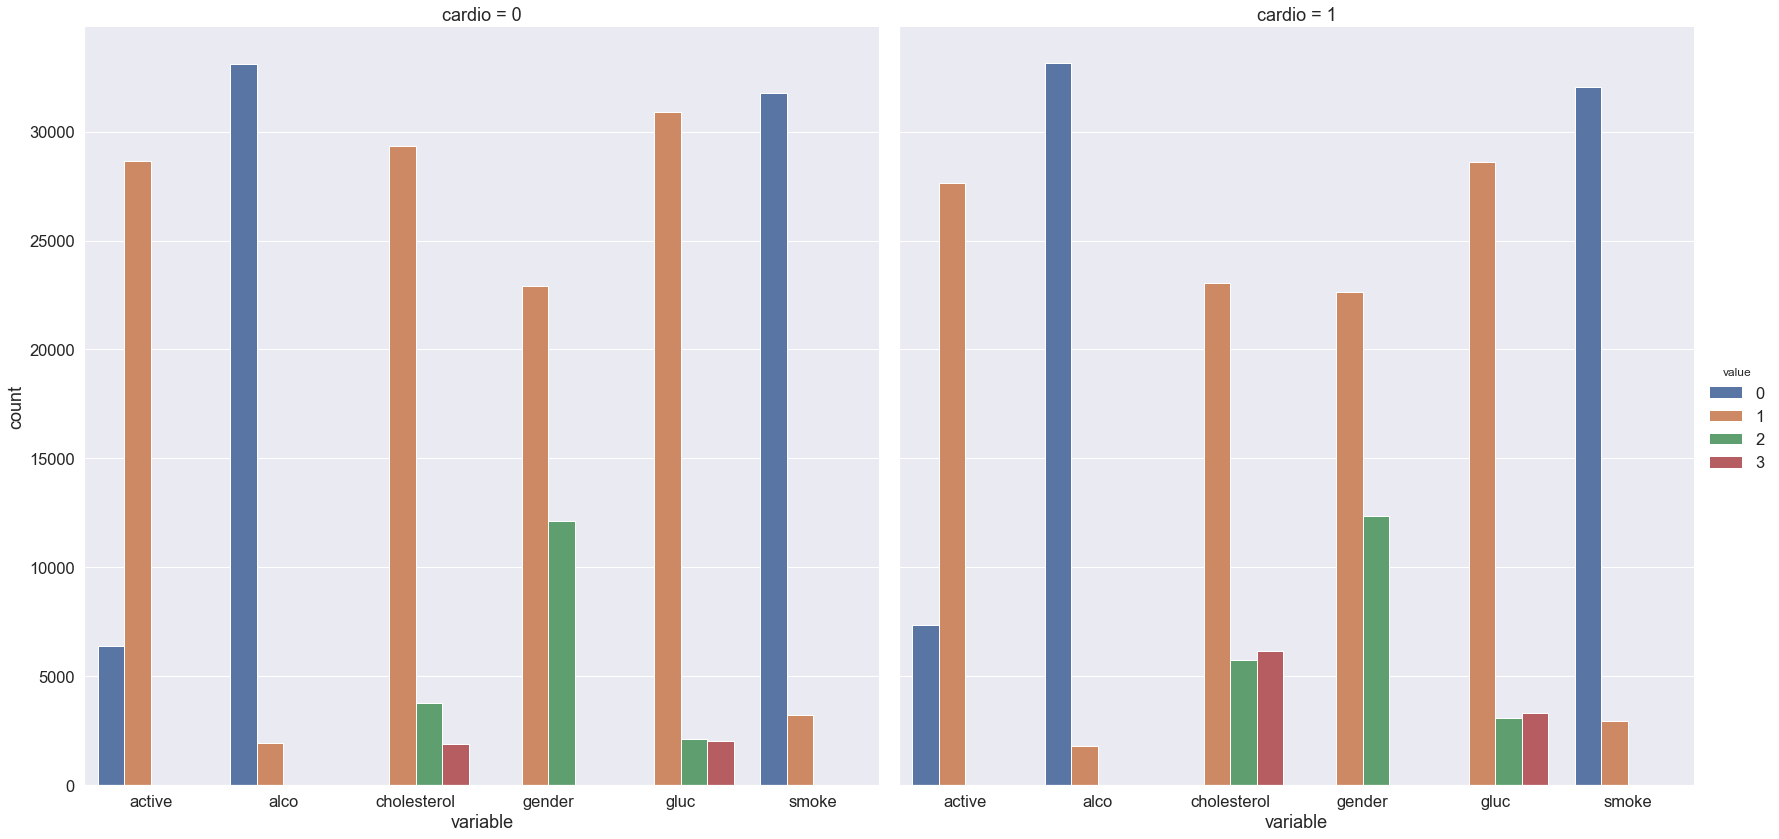

In [5]:
df_uniques = pd.melt(frame=df, value_vars=['gender', 'cholesterol',
                                           'gluc', 'smoke', 'alco',
                                           'active'], id_vars=['cardio'])

df_uniques = pd.DataFrame(df_uniques.groupby(['variable', 'value',
                                              'cardio'])['value'].count()) \
    .sort_index(level=[0,1]) \
    .rename(columns={'value': 'count'}) \
    .reset_index()

sns.catplot(x='variable', y='count', hue='value',
            col='cardio', data=df_uniques, kind='bar',height=12)

# 问题

问题：数据集中有多少男性和女性？由于 gender 特征没有说明男女，你需要通过分析身高计算得出。

[ A ] 45530 女性 和 24470 男性    
[ B ] 45530 男性 和 24470 女性    
[ C ] 45470 女性 和 24530 男性    
[ D ] 45470 男性 和 24530 女性  

A

In [6]:
print(df.groupby('gender')['height'].mean())
print(df['gender'].value_counts())

gender
1    161.355612
2    169.947895
Name: height, dtype: float64
1    45530
2    24470
Name: gender, dtype: int64


问题：数据集中男性和女性，哪个群体饮酒的频次更高

男

In [7]:
df.groupby(['gender'])['alco'].mean()

gender
1    0.025500
2    0.106375
Name: alco, dtype: float64

问题：数据集中男性和女性吸烟者所占百分比的差值是多少？

In [8]:
smoke = df.groupby(['gender'])['smoke'].mean()
key = list(smoke)[1] - list(smoke)[0]
print(round(100 * key))

20


 问题：数据集中吸烟者和非吸烟者的年龄中位数之间的差值（以月计）近似是多少？你需要尝试确定出数据集中 age 合理的表示单位。    
[ A ] 5         
[ B ] 10     
[ C ] 15    
[ D ] 20    

In [9]:
age_median = df.groupby(['smoke'])['age'].median()
print((list(age_median)[0] - list(age_median)[1]) / 365.25 * 12) 

19.613963039014372


![图片](image/10_17_1.png)

让我们来看看最右上角的矩形，也就是 60 到 65 岁的吸烟男性的子集。其中，矩形的左下角看到一个值 9，在右上角看到 47。量表意味着对于收缩压（纵坐标）低于 120 （正常血压）的性别年龄组的人来说，心血管疾病的风险估计比收缩压为 [160, 180)[160,180) 的患者（高血压）低 5 倍（47/9）。

接下来，让我们结合量表，并利用挑战数据集进行计算。这里需要注意的是，量表中胆固醇（Cholesterol）水平和挑战数据单位不太一样，我们使用对应关系为：4 mmol/l \rightarrow→ 1, 5-7 mmol/l \rightarrow→ 2, 8 mmol/l \rightarrow→ 3。

问题：计算 [60, 65)[60,65) 年龄区间下，较健康人群（胆固醇类别 1，收缩压低于 120）与高风险人群（胆固醇类别为 3，收缩压 [160, 180)[160,180)）各自心血管病患所占比例。并最终求得二者比例的近似倍数。

[ A ] 1    
[ B ] 2    
[ C ] 3    
[ D ] 4    

增加年龄列

In [10]:
df['age_years'] = (df['age'] / 365.25).round().astype('int')

选出[60, 65)区间的人

In [11]:
old = df[(df['age_years'] >=60) & (df['age_years'] < 65) &
         (df['smoke'] == 1) & (df['gender'] == 2)]

健康人群患病的几率

In [12]:
fitness_old = old[(old['cholesterol'] == 1) & 
                  (old['ap_hi'] < 120)]['cardio'].mean()
fitness_old

0.2631578947368421

高风险人群患病的几率

In [13]:
high_stake_old = old[(old['cholesterol'] == 3) &
                     (old['ap_hi'] >= 160) &
                     (old['ap_hi'] < 180)]['cardio'].mean()
high_stake_old

0.8636363636363636

In [14]:
print(round(float(high_stake_old) / float(fitness_old)))

3


问题：请选择下面叙述正确的有：

[ A ] 数据集样本中 BMI 中位数在正常范围内。   
[ B ] 女性的平均 BMI 指数高于男性。   
[ C ] 健康人群的 BMI 平均高于患病人群。   
[ D ] 健康和不饮酒男性中，BMI 比健康不饮酒女性更接近正常值。   

In [15]:
df['BMI'] = df['weight'] / ((df['height'] / 100) ** 2)
df['BMI'].median()

26.374068120774975

In [16]:
df.groupby('gender')['BMI'].mean()

gender
1    27.987583
2    26.754442
Name: BMI, dtype: float64

In [17]:
df.groupby('cardio')['BMI'].mean().to_frame()

,BMI
cardio,
0,26.548175
1,28.566061


In [18]:
df.groupby(['cardio','alco','gender'])["BMI"].mean().to_frame()

BMI
cardio alco gender           
0      0    1       26.845407
            2       25.872638
       1    1       28.671457
            2       26.097220
1      0    1       29.052771
            2       27.522450
       1    1       30.812347
            2       28.226569

## 数据清洗
你可能会注意到给出的数据并不够完美，在进一步可视化之前，我们需要对数据进行清洗。

 问题：请按照以下列举的项目，过滤掉数据中统计有误的部分：

血压特征中，舒张压高于收缩压的样本。    
身高特征中，低于 2.5％ 分位数的样本。    
身高特征中，高于 97.5％ 分位数的样本。     
体重特征中，低于 2.5％ 分位数的样本。    
体重特征中，高于 97.5％ 分位数的样本。    

In [19]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,BMI
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50,21.967120
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55,34.927679
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,52,23.507805
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48,28.710479
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,48,23.011177


In [28]:
h_25,h_975 = df['height'].quantile([.025,.975])

In [30]:
w_25,w_975 = df['weight'].quantile([0.025,.975])

In [33]:
df_clean = df[(df['height'] >= h_25) & (df['height'] <= h_975) &
              (df['weight'] >= w_25) & (df['weight'] <= w_975) &
              (df['ap_lo'] <= df['ap_hi'])]
df_clean

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,BMI
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50,21.967120
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55,34.927679
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,52,23.507805
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48,28.710479
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,48,23.011177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69993,99991,19699,1,172,70.0,130,90,1,1,0,0,1,1,54,23.661439
69994,99992,21074,1,165,80.0,150,80,1,1,0,0,1,1,58,29.384757
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0,53,26.927438
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1,61,27.099251


问题：清洗掉的数据占原数据总量的近似百分比？

In [34]:
1 - df_clean.shape[0] / df.shape[0]

0.09630000000000005

## 数据可视化分析
要更好地理解数据集特征，接下来使用过滤之后的数据创建特征之间相关系数的矩阵。

问题：使用 heatmap() 绘制特征之间的皮尔逊相关性系数矩阵。

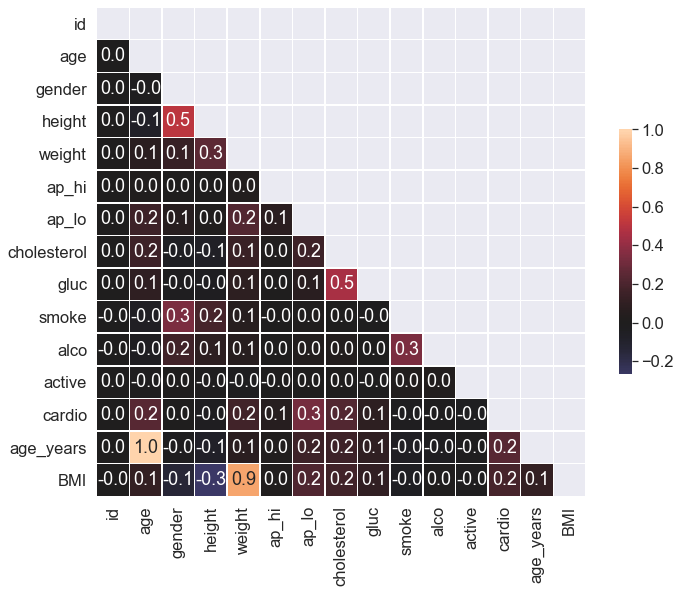

In [42]:
df_1 = df_clean.copy()
corr = df_1.corr(method='pearson')
# 创建一个Mask来隐藏相关矩阵的上三角
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# 绘制图像
f, ax = plt.subplots(figsize=(12,9))
sns.heatmap(corr, mask=mask, vmax=1, center=0, annot=True, fmt='.1f',
            square=True, linewidths=.5, cbar_kws={'shrink': .5})

 问题：以下哪组特征与性别的相关性更强？

[ A ] Cardio, Cholesterol    
[ B ] Height, Smoke    
[ C ] Smoke, Alco    
[ D ] Height, Weight 

由皮尔逊相关特性矩阵可以看出'Height'和'Smoke'

问题：绘制身高和性别之间的小提琴图 violinplot()。

这里建议通过 hue 参数按性别划分，并通过 scale 参数来计算性别对应的具体数量。为了便于你能正确绘制，这里给出一个[参考案例](https://stackoverflow.com/questions/41573283/seaborn-violin-plot-with-one-data-per-column/41575149#41575149)

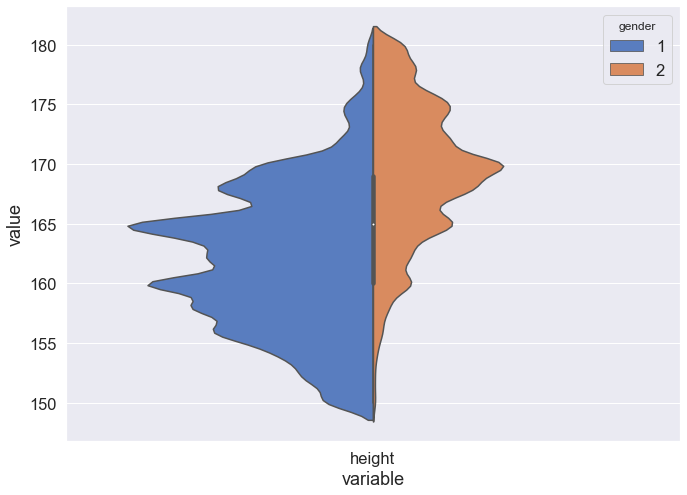

In [52]:
df_height_gender = pd.melt(df_clean, value_vars=["height",], id_vars=['gender'])
sns.violinplot(
    x='variable',
    y='value',
    hue='gender',
    palette='muted',
    split=True,
    data=df_height_gender,
    scale='count',
    scale_hue=False)

问题：绘制身高和性别之间的核密度图 kdeplot。

通过核密度图可以更清楚地看到性别之间的差异，但却无法得到每个性别对应的具体人数。

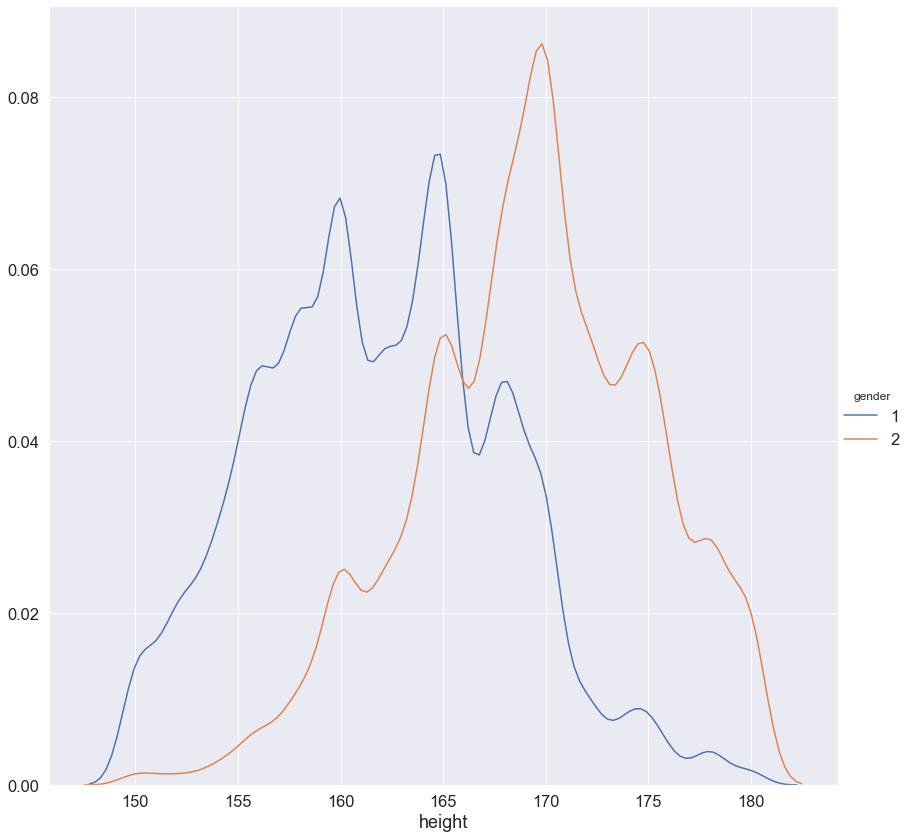

In [60]:
sns.FacetGrid(df_clean, hue='gender', height=12).map(sns.kdeplot, 'height').add_legend()

问题：使用 heatmap() 绘制特征之间的斯皮尔曼等级相关系数矩阵。

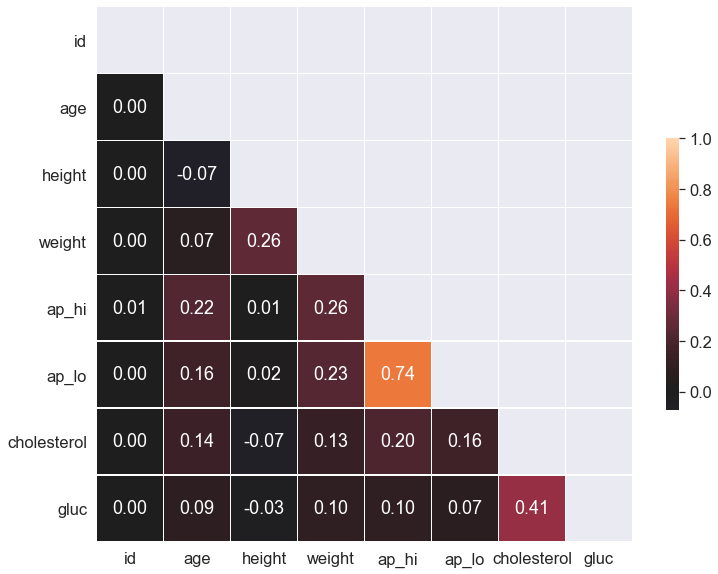

In [70]:
corr = df_clean[['id', 'age', 'height', 'weight',
           'ap_hi', 'ap_lo', 'cholesterol',
           'gluc']].corr(method='spearman')

# 创建一个mask来隐藏相关矩阵的上三角形
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# 绘制图像
f, ax = plt.subplots(figsize=(12,10))
sns.heatmap(corr, mask=mask, vmax=1, center=0, annot=True, fmt='.2f',
            square=True, linewidths=.5, cbar_kws={'shrink':.5})

问题：下列那一组特征具有最强的 Spearman 相关性？

[ A ] Height, Weight    
[ B ] Age, Weight      
[ C ] Cholesterol, Gluc     
[ D ] Cardio, Cholesterol      
[ E ] Ap_hi, Ap_lo        
[ F ] Smoke, Alco     

E

## 年龄可视化
上面，我们已经计算过受访者的年龄。接下来，我们对其进行可视化。

 问题：请使用 countplot() 绘制年龄分布计数图，横坐标为年龄，纵坐标为对应的人群数量。

In [72]:
df_clean.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,BMI
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50,21.967120
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55,34.927679
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,52,23.507805
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48,28.710479
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,48,23.011177


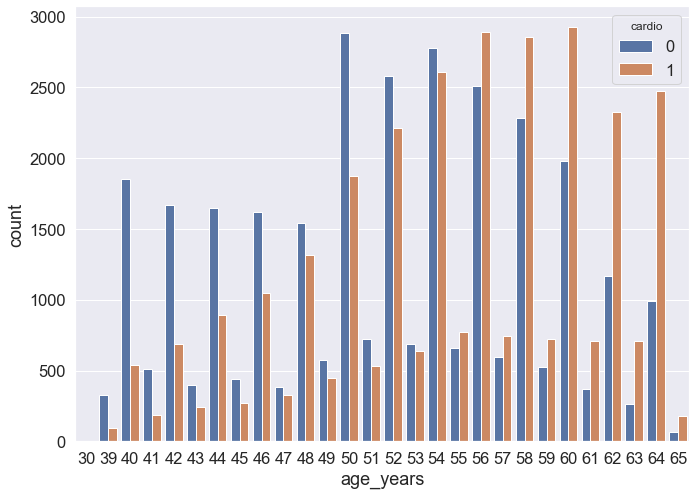

In [81]:
sns.countplot(x='age_years', hue='cardio', data=df_clean)

问题：在哪个年龄下，心血管疾病患者人数首次超过无心血管疾病患者人数？    
[ A ] 44     
[ B ] 55    
[ C ] 64    
[ D ] 70   